In [124]:
import numpy as np
import pandas as pd
import datetime
import random

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVC, SVR
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBClassifier

from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale, StandardScaler, RobustScaler
from sklearn.decomposition import PCA

# pd.set_option('display.max_columns', None)

# import warnings
# warnings.filterwarnings(action='ignore')
# pd.options.display.max_seq_items = 8000
# pd.options.display.max_rows = 8000

import os
import time
from tqdm import tqdm

In [64]:
dtypes={
    'elapsed_time':np.int32,
    'event_name':'category',
    'name':'category',
    'level':np.uint8,
    'room_coor_x':np.float32,
    'room_coor_y':np.float32,
    'screen_coor_x':np.float32,
    'screen_coor_y':np.float32,
    'hover_duration':np.float32,
    'text':'category',
    'fqid':'category',
    'room_fqid':'category',
    'text_fqid':'category',
    'fullscreen':'category',
    'hq':'category',
    'music':'category',
    'level_group':'category'}

train_data = pd.read_csv('../data/Student game/train.csv', dtype=dtypes)
train_data

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991394,-159.314682,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26296941,22100221145014656,1600,5483231,navigate_click,undefined,22,NaN,343.887299,36.701027,483.0,273.0,NaN,NaN,NaN,tunic.capitol_2.hall,NaN,0,0,1,13-22
26296942,22100221145014656,1601,5485166,navigate_click,undefined,22,NaN,332.696075,141.493179,545.0,221.0,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,0,0,1,13-22
26296943,22100221145014656,1602,5485917,navigate_click,undefined,22,NaN,369.912872,140.569199,611.0,217.0,NaN,NaN,NaN,tunic.capitol_2.hall,NaN,0,0,1,13-22
26296944,22100221145014656,1603,5486753,navigate_click,undefined,22,NaN,252.299652,123.805893,526.0,232.0,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,0,0,1,13-22


<AxesSubplot:>

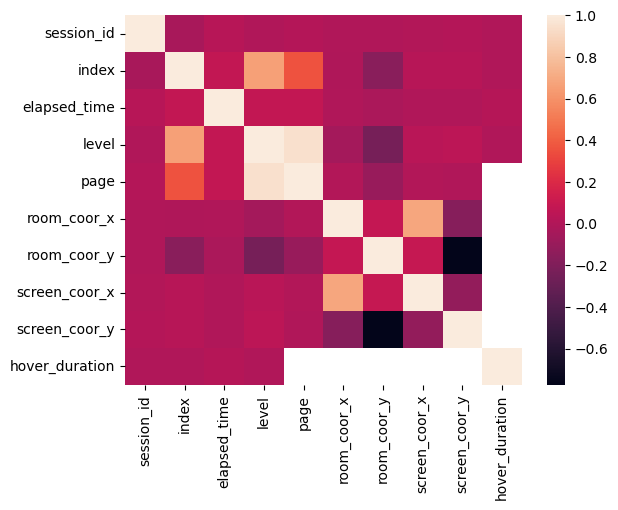

In [19]:
corr = train_data.corr()
sns.heatmap(corr)

In [20]:
train_data.describe()

,session_id,index,elapsed_time,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration
count,2.629695e+07,2.629695e+07,2.629695e+07,2.629695e+07,564544.000000,2.422367e+07,2.422367e+07,2.422367e+07,2.422367e+07,2.002244e+06
mean,2.113249e+16,6.445102e+02,4.016694e+06,1.219169e+01,3.166559,-5.490582e+01,-1.162119e+02,4.584099e+02,3.855858e+02,3.471006e+03
std,5.712953e+14,5.457880e+02,3.127032e+07,6.497789e+00,2.063291,5.202926e+02,2.184710e+02,2.479389e+02,1.298166e+02,4.602024e+05
min,2.009031e+16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,-1.992355e+03,-9.181624e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.101022e+16,2.880000e+02,4.397000e+05,6.000000e+00,1.000000,-3.528395e+02,-2.127183e+02,2.690000e+02,3.040000e+02,9.900000e+01
50%,2.104021e+16,5.950000e+02,1.014801e+06,1.300000e+01,3.000000,-1.116280e+01,-9.760534e+01,4.470000e+02,3.970000e+02,4.190000e+02
75%,2.110052e+16,8.960000e+02,1.747040e+06,1.800000e+01,5.000000,2.966515e+02,2.268786e+01,6.630000e+02,4.710000e+02,1.266000e+03
max,2.210022e+16,2.047300e+04,1.988607e+09,2.200000e+01,6.000000,1.261774e+03,5.436164e+02,1.919000e+03,1.440000e+03,2.451637e+08


In [21]:
train_data[train_data['session_id'] == 20090312431273200][train_data['level'] == 0]

/var/folders/92/qqyym7k148n9fszn9s5dlt0m0000gn/T/ipykernel_14468/2745746968.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_data[train_data['session_id'] == 20090312431273200][train_data['level'] == 0]


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991394,-159.314682,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
5,20090312431273200,5,3423,person_click,basic,0,NaN,-412.991394,-157.314682,381.0,492.0,NaN,"Sure thing, Jo. Grab your notebook and come up...",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
6,20090312431273200,6,5197,person_click,basic,0,NaN,478.485077,-199.971680,593.0,485.0,NaN,"See you later, Teddy.",teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_0,0,0,1,0-4
7,20090312431273200,7,6180,person_click,basic,0,NaN,503.355133,-168.619919,609.0,453.0,NaN,I get to go to Gramps's meeting!,teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_0,0,0,1,0-4
8,20090312431273200,8,7014,person_click,basic,0,NaN,510.733429,-157.720642,615.0,442.0,NaN,Now where did I put my notebook?,teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_0,0,0,1,0-4
9,20090312431273200,9,7946,person_click,basic,0,NaN,512.048035,-153.743637,616.0,438.0,NaN,\u00f0\u0178\u02dc\u00b4,teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_0,0,0,1,0-4


In [23]:
train_label = pd.read_csv('../data/Student game/train_labels.csv')
train_label['session'] = [int(id.split('_')[0]) for id in train_label['session_id']]
train_label['q'] = [int(id.split('_')[1][1:]) for id in train_label['session_id']]
train_label

,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1
...,...,...,...,...
424111,22100215342220508_q18,1,22100215342220508,18
424112,22100215460321130_q18,1,22100215460321130,18
424113,22100217104993650_q18,1,22100217104993650,18
424114,22100219442786200_q18,1,22100219442786200,18


In [41]:
CATEGORICAL = ['event_name', 'name', 'fqid', 'room_fqid', 'text_fqid']
NUMERICAL = ['elapsed_time', 'level', 'page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'hover_duration']

def feature_engineer(df):
    dfs = []
    for c in tqdm(CATEGORICAL, 'feature_engineer_1/3'):
        tmp = df.groupby(['session_id', 'level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in tqdm(NUMERICAL, 'feature_engineer_2/3'):
        tmp = df.groupby(['session_id', 'level_group'])[c].agg('mean')
        dfs.append(tmp)
    for c in tqdm(NUMERICAL, 'feature_engineer_3/3'):
        tmp = df.groupby(['session_id', 'level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)

    df = pd.concat(dfs, axis=1)
    df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')
    return df

In [65]:
train_data = feature_engineer(train_data)
print('Full prepared dataset shape is {}'.format(train_data.shape))
train_data.head()

feature_engineer_3/3: 100%|██████████| 8/8 [00:05<00:00,  1.41it/s]

Full prepared dataset shape is (26296946, 20)


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991394,-159.314682,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


In [46]:
train_data.describe()

,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time,level,page,room_coor_x,room_coor_y,...,screen_coor_y,hover_duration,elapsed_time_std,level_std,page_std,room_coor_x_std,room_coor_y_std,screen_coor_x_std,screen_coor_y_std,hover_duration_std
count,70686.000000,70686.000000,70686.000000,70686.000000,70686.000000,7.068600e+04,70686.000000,70686.000000,70686.000000,70686.000000,...,70686.000000,7.068600e+04,7.068600e+04,70686.000000,70686.000000,70686.000000,70686.000000,70686.000000,70686.000000,7.068600e+04
mean,10.390021,3.885324,40.468650,10.268908,23.838412,2.811806e+06,9.311221,1.439995,-33.454849,-92.222832,...,379.749146,4.119625e+03,9.322398e+05,1.916549,0.038805,468.689088,183.186301,240.795420,124.016602,1.322598e+04
std,0.832923,0.799293,13.020929,2.928351,8.989095,2.289877e+07,6.523788,2.350494,80.784378,69.349052,...,36.971046,1.394260e+05,1.206491e+07,0.492239,0.785170,106.991644,48.884988,28.709135,15.844603,4.868272e+05
min,7.000000,3.000000,18.000000,5.000000,8.000000,4.591262e+02,0.923372,-1.000000,-461.440735,-409.231293,...,177.051849,-1.000000e+00,2.337003e+02,0.684670,-1.000000,261.425412,90.098533,109.415466,68.257406,-1.000000e+00
25%,10.000000,3.000000,25.000000,7.000000,15.000000,1.642777e+05,2.051613,-1.000000,-90.615677,-151.717484,...,358.117455,9.709706e+02,8.240024e+04,1.295298,-1.000000,381.066225,143.588600,222.569734,113.994303,1.368802e+03
50%,11.000000,4.000000,43.000000,11.000000,23.000000,5.882137e+05,8.140526,1.000000,-20.255626,-71.538727,...,377.843857,1.427761e+03,1.440869e+05,2.099711,0.000000,431.901352,162.941973,238.383832,122.388964,2.041432e+03
75%,11.000000,4.000000,51.000000,12.000000,32.000000,1.351434e+06,17.592593,4.000000,23.220109,-38.693486,...,397.018394,2.158794e+03,2.240529e+05,2.316163,0.735893,585.347609,233.385259,255.083349,132.067430,3.105588e+03
max,11.000000,6.000000,81.000000,17.000000,48.000000,1.191886e+09,20.222101,6.000000,328.096100,160.347992,...,986.192993,2.772298e+07,9.946229e+08,3.580235,2.715695,817.257133,349.049304,612.958607,331.833790,7.837739e+07


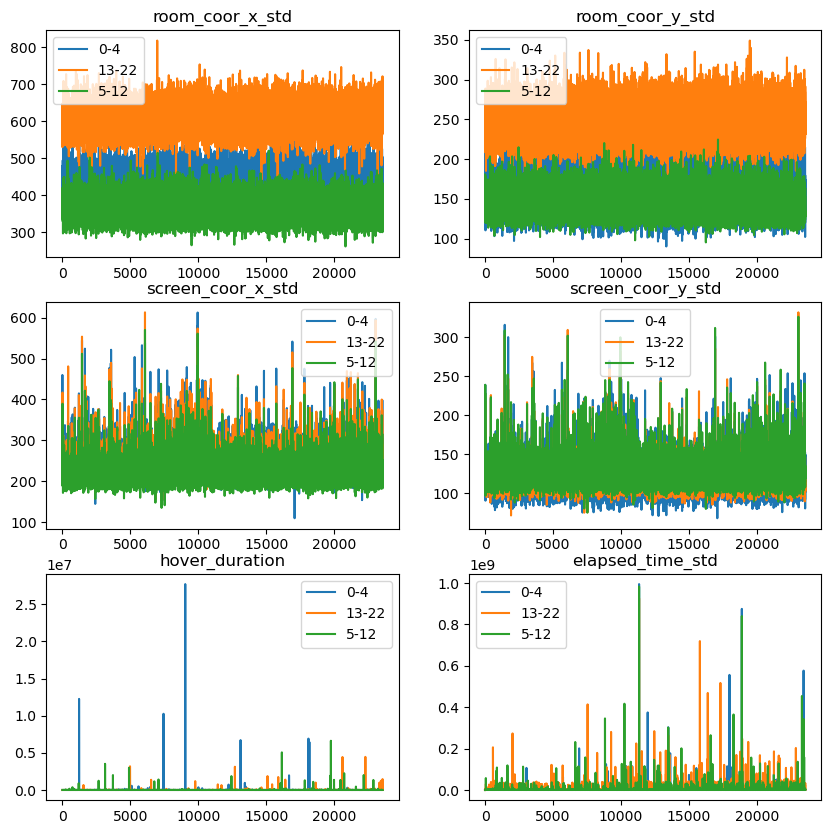

In [55]:
fig, ax = plt.subplots(3, 2, figsize=(10, 10))

for name, data in train_data.groupby('level_group'):
    for i, c in enumerate(['room_coor_x_std', 'room_coor_y_std', 'screen_coor_x_std', 'screen_coor_y_std', 'hover_duration', 'elapsed_time_std']):
        ax[i // 2, i % 2].plot(range(1, len(data[c]) + 1), data[c], label=name)
        ax[i // 2, i % 2].set_title(c)
        ax[i // 2, i % 2].legend()

plt.show()


In [68]:
def split_dataset(dataset, test_ratio=0.2):
    ids = dataset.index.unique()
    split = int(len(ids) * (1 - test_ratio))
    return dataset.loc[ids[:split]], dataset.loc[ids[split:]]

train_x, valid_x = split_dataset(train_data)
print("{} examples in training, {} examples in testing.".format(len(train_x), len(valid_x)))


56547 examples in training, 14139 examples in testing.


In [125]:
xgboost = XGBClassifier(
    learning_rate=0.01,
    n_estimators=6000,
    max_depth=4,
    min_child_weight=0,
    gamma=0.6,
    subsample=0.7,
    colsample_bytree=0.7,
    objective='reg:squarederror',
    nthread=-1,
    scale_pos_weight=1,
    seed=27,
    reg_alpha=0.00006,
    random_state=42
)

ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas))

svc = make_pipeline(RobustScaler(), SVC(C=20, gamma=0.0003))

gbr = GradientBoostingRegressor(
    n_estimators=6000,
    learning_rate=0.01,
    max_depth=4,
    max_features='sqrt',
    min_samples_leaf=15,
    min_samples_split=10,
    loss='huber',
    random_state=42
)

rf = RandomForestRegressor(
    n_estimators=1200,
    max_depth=15,
    min_samples_leaf=5,
    min_samples_split=5,
    max_features=None,
    oob_score=True,
    random_state=42
)

stack_gen = StackingCVRegressor(
    regressors=(xgboost, svr, ridge, gbr, rf),
    meta_regressor=xgboost,
    use_features_in_secondary=True
)

In [126]:
models = {}
evalations = {}

for q_no in tqdm(range(1, 19)):
    if q_no <= 3:
       grp = '0-4'
    elif q_no <= 13:
       grp = '5-12'
    elif q_no <= 18:
       grp = '13-22'
    print('Processing q_no:', q_no, ', grp:', grp)

    train_df = train_x.loc[train_x['level_group'] == grp].drop(columns=['level_group'])
    valid_df = valid_x.loc[valid_x['level_group'] == grp].drop(columns=['level_group'])

    train_labels = train_label.loc[train_label['q'] == q_no].set_index('session').loc[train_df.index.values]['correct']
    valid_labels = train_label.loc[train_label['q'] == q_no].set_index('session').loc[valid_df.index.values]['correct']

    models[f'svc_{grp}_{q_no}'] = svc.fit(train_df, train_labels)
    evalations[f'svc_{grp}_{q_no}'] = f1_score(np.array(valid_labels), models[f'svc_{grp}_{q_no}'].predict(valid_df))


  0%|          | 0/18 [00:00<?, ?it/s]

Processing q_no: 1 , grp: 0-4


  6%|▌         | 1/18 [00:20<05:54, 20.83s/it]

Processing q_no: 2 , grp: 0-4


 11%|█         | 2/18 [00:23<02:42, 10.15s/it]

Processing q_no: 3 , grp: 0-4


 17%|█▋        | 3/18 [00:29<02:04,  8.28s/it]

Processing q_no: 4 , grp: 5-12


 22%|██▏       | 4/18 [00:47<02:47, 11.96s/it]

Processing q_no: 5 , grp: 5-12


 28%|██▊       | 5/18 [00:59<02:38, 12.21s/it]

Processing q_no: 6 , grp: 5-12


 33%|███▎      | 6/18 [01:17<02:50, 14.22s/it]

Processing q_no: 7 , grp: 5-12


 39%|███▉      | 7/18 [01:39<03:02, 16.58s/it]

Processing q_no: 8 , grp: 5-12


 44%|████▍     | 8/18 [01:56<02:48, 16.88s/it]

Processing q_no: 9 , grp: 5-12


 50%|█████     | 9/18 [02:15<02:37, 17.46s/it]

Processing q_no: 10 , grp: 5-12


 56%|█████▌    | 10/18 [02:28<02:07, 15.97s/it]

Processing q_no: 11 , grp: 5-12


 61%|██████    | 11/18 [02:44<01:52, 16.06s/it]

Processing q_no: 12 , grp: 5-12


 67%|██████▋   | 12/18 [02:56<01:29, 14.96s/it]

Processing q_no: 13 , grp: 5-12


 72%|███████▏  | 13/18 [03:13<01:16, 15.28s/it]

Processing q_no: 14 , grp: 13-22


 78%|███████▊  | 14/18 [03:29<01:02, 15.54s/it]

Processing q_no: 15 , grp: 13-22


 83%|████████▎ | 15/18 [03:41<00:43, 14.59s/it]

Processing q_no: 16 , grp: 13-22


 89%|████████▉ | 16/18 [04:09<00:37, 18.74s/it]

Processing q_no: 17 , grp: 13-22


 94%|█████████▍| 17/18 [04:37<00:21, 21.43s/it]

Processing q_no: 18 , grp: 13-22


100%|██████████| 18/18 [04:44<00:00, 15.79s/it]


In [127]:
for name, value in evalations.items():
    print(f'question {name}: accuracy {value:.4f}')
print('Average accuracy:', sum(evalations.values()) / 18)

question xgboost_0-4_1: accuracy 0.8446
question xgboost_0-4_2: accuracy 0.9875
question xgboost_0-4_3: accuracy 0.9662
question xgboost_5-12_4: accuracy 0.8831
question xgboost_5-12_5: accuracy 0.7140
question xgboost_5-12_6: accuracy 0.8801
question xgboost_5-12_7: accuracy 0.8538
question xgboost_5-12_8: accuracy 0.7739
question xgboost_5-12_9: accuracy 0.8605
question xgboost_5-12_10: accuracy 0.6534
question xgboost_5-12_11: accuracy 0.7877
question xgboost_5-12_12: accuracy 0.9303
question xgboost_5-12_13: accuracy 0.0045
question xgboost_13-22_14: accuracy 0.8419
question xgboost_13-22_15: accuracy 0.6241
question xgboost_13-22_16: accuracy 0.8549
question xgboost_13-22_17: accuracy 0.8249
question xgboost_13-22_18: accuracy 0.9752
Average accuracy: 0.7922543805533405


In [139]:
for i in range(3):
    valid_df = valid_x.loc[valid_x.index[i]]
    preds = []
    for lg in valid_df['level_group']:
        if lg == '0-4':
            preds.append(models[f'xgboost_{lg}_1'].predict(valid_df[valid_df['level_group'] == lg].drop(columns=['level_group'])))
            preds.append(models[f'xgboost_{lg}_2'].predict(valid_df[valid_df['level_group'] == lg].drop(columns=['level_group'])))
            preds.append(models[f'xgboost_{lg}_3'].predict(valid_df[valid_df['level_group'] == lg].drop(columns=['level_group'])))
        elif lg == '5-12':
            preds.append(models[f'xgboost_{lg}_4'].predict(valid_df[valid_df['level_group'] == lg].drop(columns=['level_group'])))
            preds.append(models[f'xgboost_{lg}_5'].predict(valid_df[valid_df['level_group'] == lg].drop(columns=['level_group'])))
            preds.append(models[f'xgboost_{lg}_6'].predict(valid_df[valid_df['level_group'] == lg].drop(columns=['level_group'])))
            preds.append(models[f'xgboost_{lg}_7'].predict(valid_df[valid_df['level_group'] == lg].drop(columns=['level_group'])))
            preds.append(models[f'xgboost_{lg}_8'].predict(valid_df[valid_df['level_group'] == lg].drop(columns=['level_group'])))
            preds.append(models[f'xgboost_{lg}_9'].predict(valid_df[valid_df['level_group'] == lg].drop(columns=['level_group'])))
            preds.append(models[f'xgboost_{lg}_10'].predict(valid_df[valid_df['level_group'] == lg].drop(columns=['level_group'])))
            preds.append(models[f'xgboost_{lg}_11'].predict(valid_df[valid_df['level_group'] == lg].drop(columns=['level_group'])))
            preds.append(models[f'xgboost_{lg}_12'].predict(valid_df[valid_df['level_group'] == lg].drop(columns=['level_group'])))
            preds.append(models[f'xgboost_{lg}_13'].predict(valid_df[valid_df['level_group'] == lg].drop(columns=['level_group'])))
        elif lg == '13-22':
            preds.append(models[f'xgboost_{lg}_14'].predict(valid_df[valid_df['level_group'] == lg].drop(columns=['level_group'])))
            preds.append(models[f'xgboost_{lg}_15'].predict(valid_df[valid_df['level_group'] == lg].drop(columns=['level_group'])))
            preds.append(models[f'xgboost_{lg}_16'].predict(valid_df[valid_df['level_group'] == lg].drop(columns=['level_group'])))
            preds.append(models[f'xgboost_{lg}_17'].predict(valid_df[valid_df['level_group'] == lg].drop(columns=['level_group'])))
            preds.append(models[f'xgboost_{lg}_18'].predict(valid_df[valid_df['level_group'] == lg].drop(columns=['level_group'])))
    print(np.concatenate(preds))



[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [147]:
for i in range(3):
    valid_label = train_label[train_label['session_id'].str.contains(str(valid_x.index[i]))]
    print(np.array(valid_label['correct']))

[1 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1]
[1 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1]
[1 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1]


In [141]:
train_label

,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1
...,...,...,...,...
424111,22100215342220508_q18,1,22100215342220508,18
424112,22100215460321130_q18,1,22100215460321130,18
424113,22100217104993650_q18,1,22100217104993650,18
424114,22100219442786200_q18,1,22100219442786200,18
